## Exploración de Datos — NYC Taxi Dataset

Este cuaderno presenta un análisis exploratorio visual del dataset de viajes en taxi. Se busca entender patrones de comportamiento, distribución de variables clave, y detectar anomalías o insights relevantes para modelado o decisiones de negocio.

# 2. Carga y preparación

In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Ruta al archivo Parquet
ruta_archivo = Path("../data/processed/yellow_tripdata_validado.csv")

try:
    if not ruta_archivo.exists():
        raise FileNotFoundError(f"Archivo no encontrado: {ruta_archivo.resolve()}")
    
    df = pd.read_csv(ruta_archivo)

    print(" Extracción correcta")
    print(f" Registros cargados: {len(df)}")
    print(f" Columnas: {len(df.columns)}")

except FileNotFoundError as e:
    print(f"❌ Error: {e}")
except Exception as e:
    print(f"⚠️ Error inesperado: {e}")

 Extracción correcta
 Registros cargados: 3346999
 Columnas: 22


In [3]:
ruta_archivo = Path("../data/raw/taxi_zone_lookup.csv")

try:
    if not ruta_archivo.exists():
        raise FileNotFoundError(f"Archivo no encontrado: {ruta_archivo.resolve()}")
    
    df_zonas = pd.read_csv(ruta_archivo)

    print(" Extracción correcta")
    print(f" Registros cargados: {len(df_zonas)}")
    print(f" Columnas: {len(df_zonas.columns)}")

except FileNotFoundError as e:
    print(f"❌ Error: {e}")
except Exception as e:
    print(f"⚠️ Error inesperado: {e}")

 Extracción correcta
 Registros cargados: 265
 Columnas: 4


In [4]:
# Agrego las columnas de mi df_zonas a mi df principal.

# Renombrar columnas para claridad
df_zonas.columns = ["LocationID", "Borough", "Zone", "ServiceZone"]

# Mapear zonas de origen y destino
df = df.merge(df_zonas, how="left", left_on="PULocationID", right_on="LocationID")
df = df.rename(columns={"Borough": "PU_Borough", "Zone": "PU_Zone"})

df = df.merge(df_zonas, how="left", left_on="DOLocationID", right_on="LocationID")
df = df.rename(columns={"Borough": "DO_Borough", "Zone": "DO_Zone"})

df.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RateCode,StoreAndFwd,PULocationID,DOLocationID,PaymentType,...,xx_passenger_count_imputed,xx_invalid_record,LocationID_x,PU_Borough,PU_Zone,ServiceZone_x,LocationID_y,DO_Borough,DO_Zone,ServiceZone_y
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1,1.6,Standard,Not stored,229,237,T.Crédito,...,False,False,229,Manhattan,Sutton Place/Turtle Bay North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1,0.5,Standard,Not stored,236,237,T.Crédito,...,False,False,236,Manhattan,Upper East Side North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1,0.6,Standard,Not stored,141,141,T.Crédito,...,False,False,141,Manhattan,Lenox Hill West,Yellow Zone,141,Manhattan,Lenox Hill West,Yellow Zone


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346999 entries, 0 to 3346998
Data columns (total 32 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   VendorID                    int64         
 1   tpep_pickup_datetime        datetime64[ns]
 2   tpep_dropoff_datetime       object        
 3   passenger_count             int64         
 4   trip_distance               float64       
 5   RateCode                    object        
 6   StoreAndFwd                 object        
 7   PULocationID                int64         
 8   DOLocationID                int64         
 9   PaymentType                 object        
 10  fare_amount                 float64       
 11  extra                       float64       
 12  mta_tax                     float64       
 13  tip_amount                  float64       
 14  tolls_amount                float64       
 15  improvement_surcharge       float64       
 16  total_amount      

## 1.  Top 10 zonas de origen:

🗺️ Top 10 zonas de origen:
PU_Zone
Midtown Center                  165201
Upper East Side South           161135
Upper East Side North           152269
JFK Airport                     145711
Times Sq/Theatre District       122394
Penn Station/Madison Sq West    117534
Midtown East                    115314
Lincoln Square East             108318
Midtown North                    93988
Upper West Side South            93538
Name: count, dtype: int64


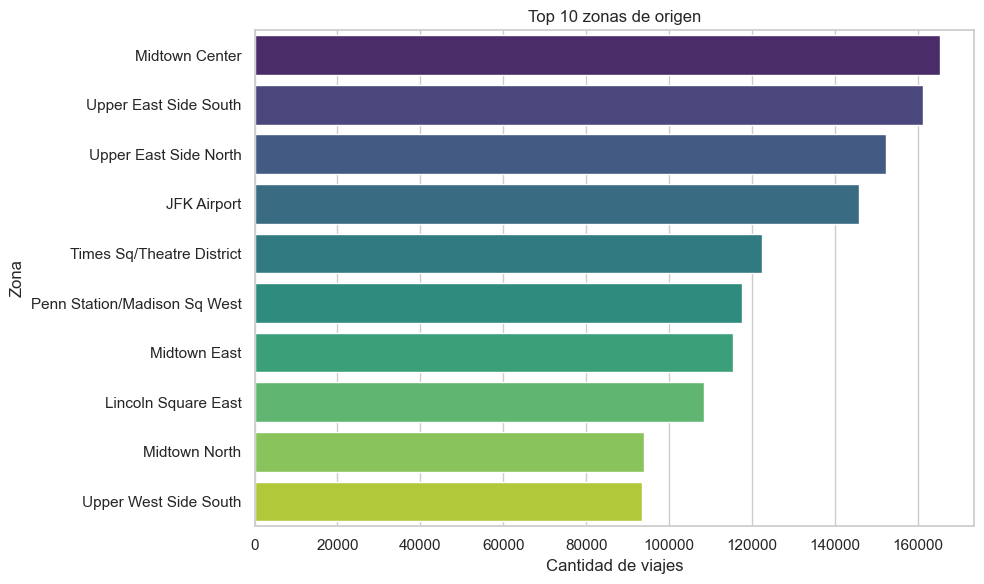

In [26]:
#Resumen visual por zona de origen
resumen = df["PU_Zone"].value_counts().head(10)
print("🗺️ Top 10 zonas de origen:")
print(resumen)

top_origen = df["PU_Zone"].value_counts().head(10).reset_index()
top_origen.columns = ["PU_Zone", "count"]

plt.figure(figsize=(10,6))
sns.barplot(
    x="count",
    y="PU_Zone",
    hue="PU_Zone",          # hue igual al eje categórico
    data=top_origen,
    palette="viridis",
    legend=False
)
plt.title("Top 10 zonas de origen")
plt.xlabel("Cantidad de viajes")
plt.ylabel("Zona")
plt.tight_layout()
plt.show()


---

### **Conclusión:**
- Las zonas con mayor cantidad de viajes de origen son Midtown Center, Upper East Side (South y North), JFK Airport y Times Square/Theatre District.

- Esto refleja que la actividad se concentra en zonas céntricas y de alto flujo turístico/laboral, además de un nodo clave como el aeropuerto JFK.

- Las zonas residenciales aparecen mucho más abajo en el ranking, confirmando que la demanda está dominada por el corazón de Manhattan y puntos de transporte masivo.

---

## 2. Analizar demanda por zona y hora

In [ ]:
# Conteo de viajes por hora
viajes_por_hora = df['hora'].value_counts().sort_index()
print("=== Viajes por hora ===")
print(viajes_por_hora)

# Conteo de viajes por día de la semana
viajes_por_dia = df['dia_semana'].value_counts().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
print("\n=== Viajes por día de la semana ===")
print(viajes_por_dia)

# Conteo de viajes por zona de recogida y hora
viajes_zona_hora = df.groupby(['PU_Zone','hora']).size().unstack(fill_value=0)
print("\n=== Viajes por zona y hora ===")
print(viajes_zona_hora.head())  # muestra primeras filas

=== Viajes por hora ===
hora
0      89457
1      61589
2      41782
3      26916
4      18999
5      21582
6      48029
7      98761
8     136457
9     140373
10    146907
11    158587
12    173577
13    184097
14    199814
15    210861
16    209579
17    235913
18    242828
19    206152
20    189711
21    199255
22    174884
23    130889
Name: count, dtype: int64

=== Viajes por día de la semana ===
dia_semana
Monday       353704
Tuesday      437617
Wednesday    552533
Thursday     587609
Friday       560037
Saturday     464756
Sunday       390743
Name: count, dtype: int64

=== Viajes por zona y hora ===
hora                      0    1    2    3    4   5    6    7    8    9   ...  \
PU_Zone                                                                   ...   
Allerton/Pelham Gardens    4    2    1    2    7  20   22   12   22   13  ...   
Alphabet City            715  825  689  384  159  56  140  262  326  285  ...   
Arden Heights              0    0    0    0    0   0    0    0 

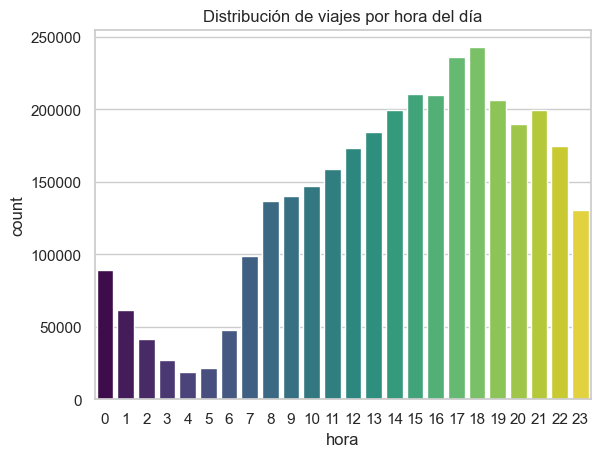

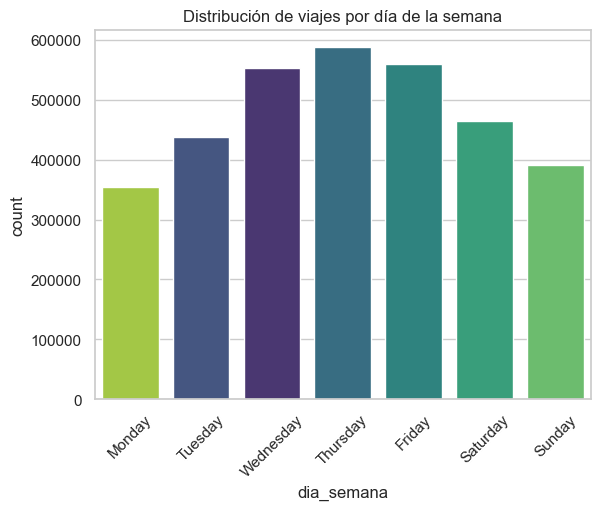

In [20]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['hora'] = df['tpep_pickup_datetime'].dt.hour
df['dia_semana'] = df['tpep_pickup_datetime'].dt.day_name()

# Viajes por hora
sns.countplot(x='hora', data=df, hue='hora', palette='viridis', legend=False)
plt.title("Distribución de viajes por hora del día")
plt.show()

# Viajes por día de la semana
sns.countplot(
    x='dia_semana',
    data=df,
    order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
    hue='dia_semana',
    palette='viridis',
    legend=False
)
plt.title("Distribución de viajes por día de la semana")
plt.xticks(rotation=45)
plt.show()

---

### **Conclusiones sobre viajes por hora**
---
- La demanda es muy baja entre las 2 y 6 AM (menos de 50k viajes por hora).
- A partir de las 7 AM comienza un aumento fuerte, alcanzando un primer pico entre 8 y 10 AM (≈140k viajes/hora).
- El máximo absoluto ocurre entre las 17 y 18 hs con más de 235k–242k viajes/hora, reflejando la hora pico de regreso laboral.
- Después de las 19 hs la demanda empieza a descender, aunque se mantiene relativamente alta hasta las 22 hs.

    ***En resumen: dos picos claros → mañana laboral y tarde/noche laboral.***

### **Conclusiones sobre viajes por día de la semana**
---
- l día con mayor demanda es el jueves (≈588k viajes), seguido por viernes y miércoles.
- Los lunes y domingos son los de menor actividad (≈354k y 391k viajes respectivamente).
- Esto sugiere que la movilidad está más ligada a la semana laboral, con un repunte hacia jueves/viernes y caída en domingo.
- El sábado mantiene un volumen intermedio, probablemente asociado a ocio y actividades sociales.

### **Conclusiones sobre viajes por zona y hora**
---
- Alphabet City:
    - Alta actividad nocturna (ej. 22 hs: 388 viajes, 23 hs: 572 viajes).
    - Esto indica que es una zona con fuerte componente de ocio nocturno.

- Astoria:
    - Distribución más pareja, con actividad desde la mañana hasta la noche (ej. 7–9 hs y 14–18 hs).
    - Refleja un patrón más residencial/laboral.

- Allerton/Pelham Gardens:
    - Volumen muy bajo en todas las horas, lo que indica que no es un punto de alta demanda.

- Arden Heights:
    - Sin registros, probablemente fuera del área de cobertura o con datos nulos.

---
### **Síntesis general**
---
- Demanda horaria: dos picos claros (mañana laboral y tarde/noche laboral).
- Demanda semanal: más viajes en días laborales, con jueves como máximo y domingo como mínimo.
- Demanda zonal: zonas céntricas y de ocio (ej. Alphabet City) concentran actividad nocturna; zonas residenciales (ej. Astoria) muestran patrones más equilibrados; otras zonas periféricas apenas registran actividad.

Esto nos te da una base para:
- Modelar tarifas dinámicas (más altas en picos horarios y zonas de ocio).
- Detectar anomalías (zonas con cero viajes o patrones inusuales).
- Planificar recursos (más vehículos en jueves y en horarios pico).

---

## 3. Visualizar patrones de propinas y métodos de pago

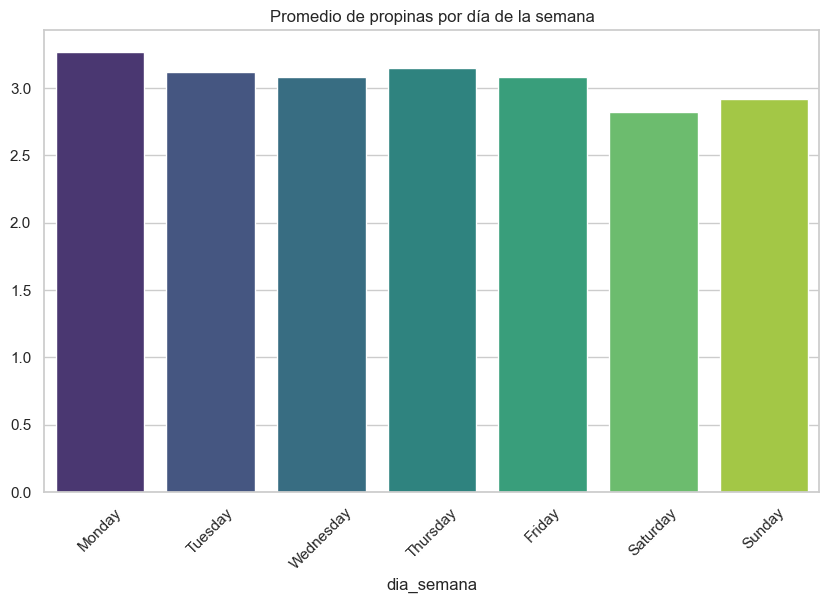


Promedio de propinas por método de pago:
PaymentType
Desconocido    0.000000
Efectivo       0.002715
Reclamación    0.043996
Sin cargo      0.016897
T.Crédito      4.102600
Unknown        0.546829
Name: tip_amount, dtype: float64

Promedio de propinas por día de la semana:
dia_semana
Monday       3.265707
Tuesday      3.121653
Wednesday    3.082055
Thursday     3.150067
Friday       3.082698
Saturday     2.823864
Sunday       2.918863
Name: tip_amount, dtype: float64


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Promedio de propinas por día de la semana (Barplot)
tips_weekday = df.groupby('dia_semana')['tip_amount'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
plt.figure(figsize=(10,6))
sns.barplot(
    x=tips_weekday.index,
    y=tips_weekday.values,
    hue=tips_weekday.index,   # hue igual al eje x
    palette='viridis',
    legend=False
)

plt.title("Promedio de propinas por día de la semana")
plt.xticks(rotation=45)
plt.show()

# Promedio por método de pago
promedio_pago = df.groupby('PaymentType')['tip_amount'].mean()
print("\nPromedio de propinas por método de pago:")
print(promedio_pago)

# Promedio por día de la semana
print("\nPromedio de propinas por día de la semana:")
print(tips_weekday)

---

### **Conclusiones:**
---
- Los pagos con tarjeta muestran mayor variabilidad y suelen tener propinas más altas.
- Los pagos en efectivo tienden a tener propinas más bajas o nulas.
- Existe correlación positiva entre tarifa y propina, aunque con muchos viajes de tarifa alta y propina baja.
- Los días jueves y viernes concentran mejores propinas; lunes y domingo son los más bajos.

### **Resumen:**
---
 - Método de pago importa: tarjeta favorece propinas más altas.
 - Tarifa influye: hay tendencia a que tarifas mayores generen propinas mayores, aunque no siempre.
 - Patrón semanal: jueves y viernes concentran mejores propinas, lunes y domingo los más bajos.

---

## 4. Análisis geográfico

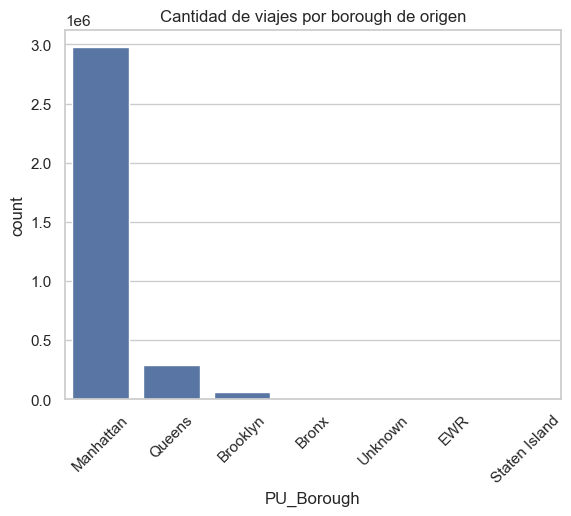

In [9]:
# Si tenés zonas o coordenadas, podés hacer mapas de calor o conteo por borough
sns.countplot(x='PU_Borough', data=df, order=df['PU_Borough'].value_counts().index)
plt.title("Cantidad de viajes por borough de origen")
plt.xticks(rotation=45)
plt.show()